In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni_df):
    uni_df = uni_df[uni_df['Participant Profile']=='Learner']
    uni_df = uni_df[uni_df['Activity (mob)'].str.contains('Student')]
    uni_df = uni_df[~uni_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni_df.loc[:, 'Sending Organization' ]), set(uni_df.loc[:, 'Receiving Organization']))))
    uni_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni_df['Sending Organization']))))
    uni_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    uni_df['Receiving Organization']= (np.array(list(map(lambda x: replace_iso3166(x), uni_df['Receiving Organization']))))
    uni_df['Sending Organization']= (np.array(list(map(lambda x: replace_iso3166(x), uni_df['Sending Organization']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

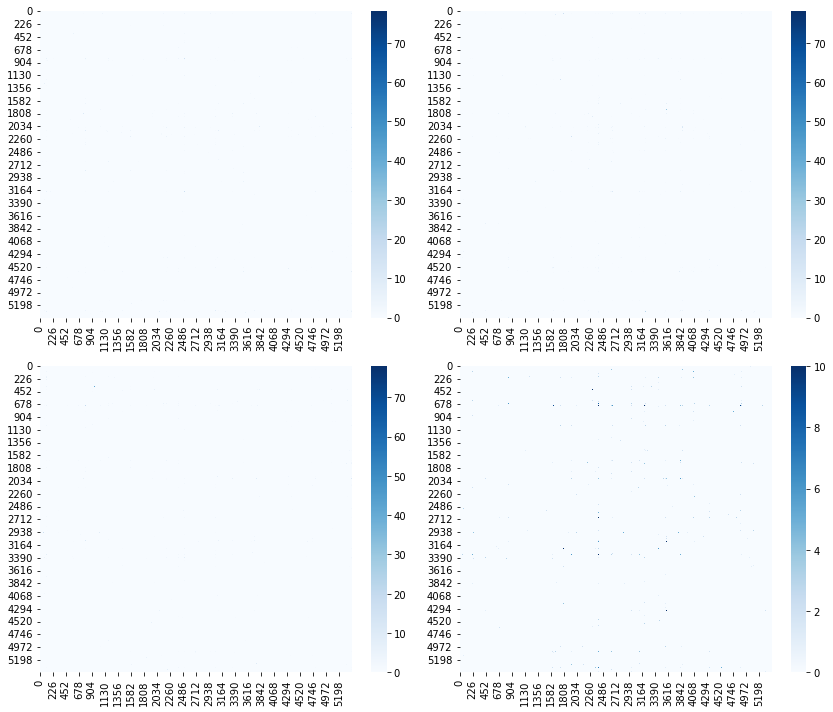

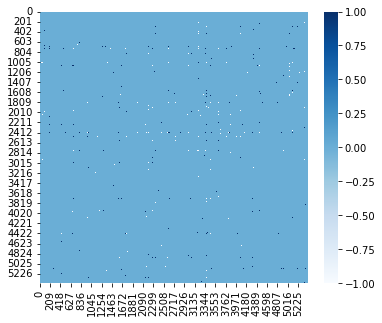

Number of components = 17


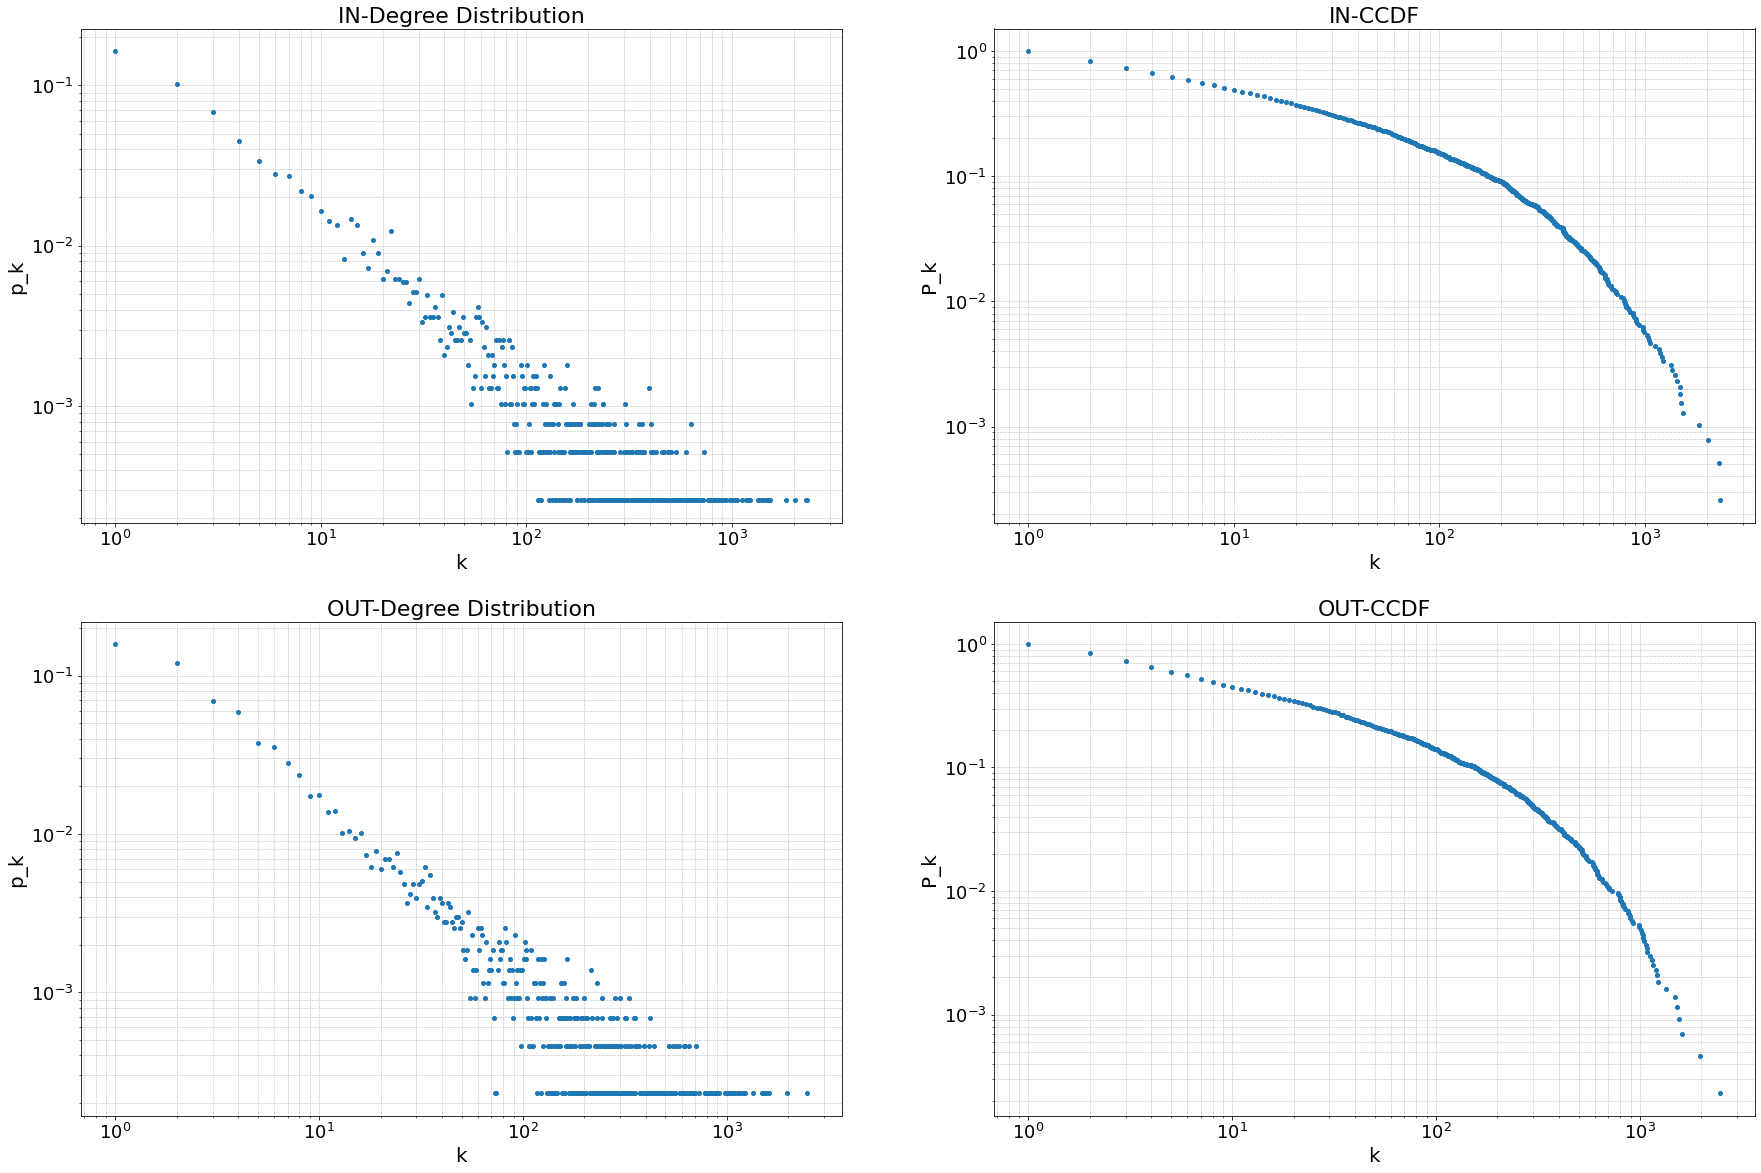

Top 10 for in degree


,Nodes,in degree
4551,UNIVERSITAT DE VALENCIA,2329
1513,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2297
211,UNIVERSIDADE DE LISBOA,2039
2411,UNIVERSIDAD DE GRANADA,1832
5381,UNIVERSIDAD COMPLUTENSE DE MADRID,1535
5411,UNIVERZA V LJUBLJANI,1507
3880,UNIVERSITAT POLITECNICA DE VALENCIA,1489
2513,UNIVERZITA KARLOVA,1484
590,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1433
4902,KATHOLIEKE UNIVERSITEIT LEUVEN,1408


Top 10 for out degree


,Nodes,out degree
1513,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2478
2411,UNIVERSIDAD DE GRANADA,1970
4551,UNIVERSITAT DE VALENCIA,1614
3006,UNIVERSITA DEGLI STUDI DI PADOVA,1556
5381,UNIVERSIDAD COMPLUTENSE DE MADRID,1518
176,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1490
4490,UNIVERSITA DEGLI STUDI DI TORINO,1349
3161,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1230
4700,POLITECNICO DI MILANO,1214
4631,UNIVERSIDAD DE SEVILLA,1198


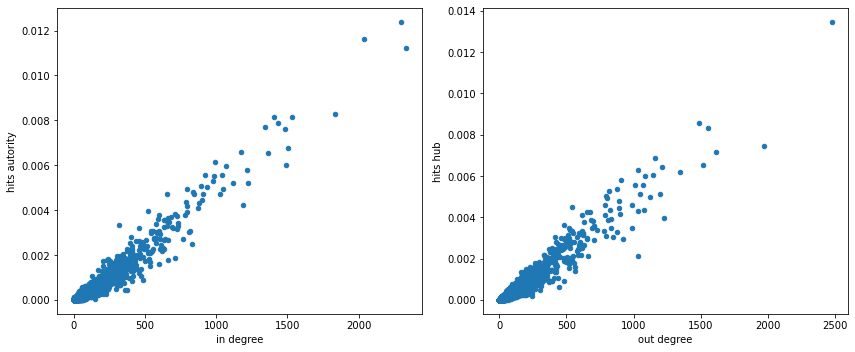

Top 10 for hits hub


,Nodes,hits hub
1513,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013433
176,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.008579
3006,UNIVERSITA DEGLI STUDI DI PADOVA,0.008316
2411,UNIVERSIDAD DE GRANADA,0.007472
4551,UNIVERSITAT DE VALENCIA,0.007149
211,UNIVERSIDADE DE LISBOA,0.006850
5381,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006546
4700,POLITECNICO DI MILANO,0.006413
3615,TECHNISCHE UNIVERSITAET MUENCHEN,0.006302
4490,UNIVERSITA DEGLI STUDI DI TORINO,0.006184


Top 10 for hits autority


,Nodes,hits autority
1513,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.012363
211,UNIVERSIDADE DE LISBOA,0.011628
4551,UNIVERSITAT DE VALENCIA,0.011203
2411,UNIVERSIDAD DE GRANADA,0.008268
5381,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008167
4902,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008154
590,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007880
4631,UNIVERSIDAD DE SEVILLA,0.007694
2513,UNIVERZITA KARLOVA,0.007619
5411,UNIVERZA V LJUBLJANI,0.006769


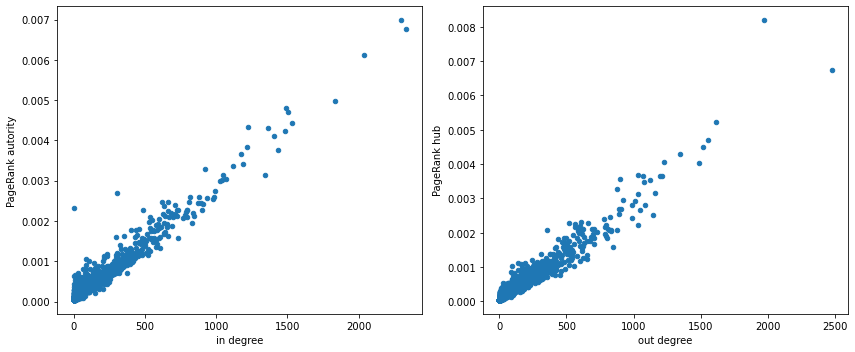

Top 10 for PageRank hub


,Nodes,PageRank hub
2411,UNIVERSIDAD DE GRANADA,0.008190
1513,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006736
4551,UNIVERSITAT DE VALENCIA,0.005238
3006,UNIVERSITA DEGLI STUDI DI PADOVA,0.004704
5381,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004486
4490,UNIVERSITA DEGLI STUDI DI TORINO,0.004291
3161,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004049
176,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004037
3993,UNIVERSIDAD REY JUAN CARLOS,0.003677
4700,POLITECNICO DI MILANO,0.003665


Top 10 for PageRank authority


KeyError: 'PageRank authority'

In [5]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)